In [ ]:
import os
import torch as t
import torchvision.models
import torch
import torch.nn as nn
image = torch.zeros((1, 3, 800, 800)).float()
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background
sub_sample = 16

In [ ]:
import torchvision
dummy_img = torch.zeros((1, 3, 800, 800)).float()
print(dummy_img)
#Out: torch.Size([1, 3, 800, 800])
model=torchvision.models.alexnet(pretrained=True)
# model=torchvision.models.vgg16(pretrained=True)
fe=list(model.features)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
req_features = []
k = dummy_img.clone()
#fe is the layers or features of each layers
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))
print(out_channels)

5
192


In [ ]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [ ]:
out_map = faster_rcnn_fe_extractor(image)
print(out_map.size())

torch.Size([1, 192, 99, 99])


In [ ]:
import numpy as np
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]
anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
ctr_y = sub_sample / 2.
ctr_x = sub_sample / 2.
for i in range(len(ratios)):
  for j in range(len(anchor_scales)):
    h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
    w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
    index = i * len(anchor_scales) + j
    anchor_base[index, 0] = ctr_y - h / 2.
    anchor_base[index, 1] = ctr_x - w / 2.
    anchor_base[index, 2] = ctr_y + h / 2.
    anchor_base[index, 3] = ctr_x + w / 2.

In [ ]:
#9 anchors with one feature map pixel
print(anchor_base)

[[ -37.254833  -82.50967    53.254833   98.50967 ]
 [ -82.50967  -173.01933    98.50967   189.01933 ]
 [-173.01933  -354.03867   189.01933   370.03867 ]
 [ -56.        -56.         72.         72.      ]
 [-120.       -120.        136.        136.      ]
 [-248.       -248.        264.        264.      ]
 [ -82.50967   -37.254833   98.50967    53.254833]
 [-173.01933   -82.50967   189.01933    98.50967 ]
 [-354.03867  -173.01933   370.03867   189.01933 ]]


In [ ]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
index = 0
ctr = np.zeros((ctr_x.shape[0]*ctr_y.shape[0], 2), dtype=np.float32)
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 2
        ctr[index, 0] = ctr_y[y] - 2
        index +=1

In [ ]:
anchors = np.zeros(((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
      h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
      w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
      anchors[index, 0] = ctr_y - h / 2.
      anchors[index, 1] = ctr_x - w / 2.
      anchors[index, 2] = ctr_y + h / 2.
      anchors[index, 3] = ctr_x + w / 2.
      index += 1
print(anchors.shape)

(22500, 4)


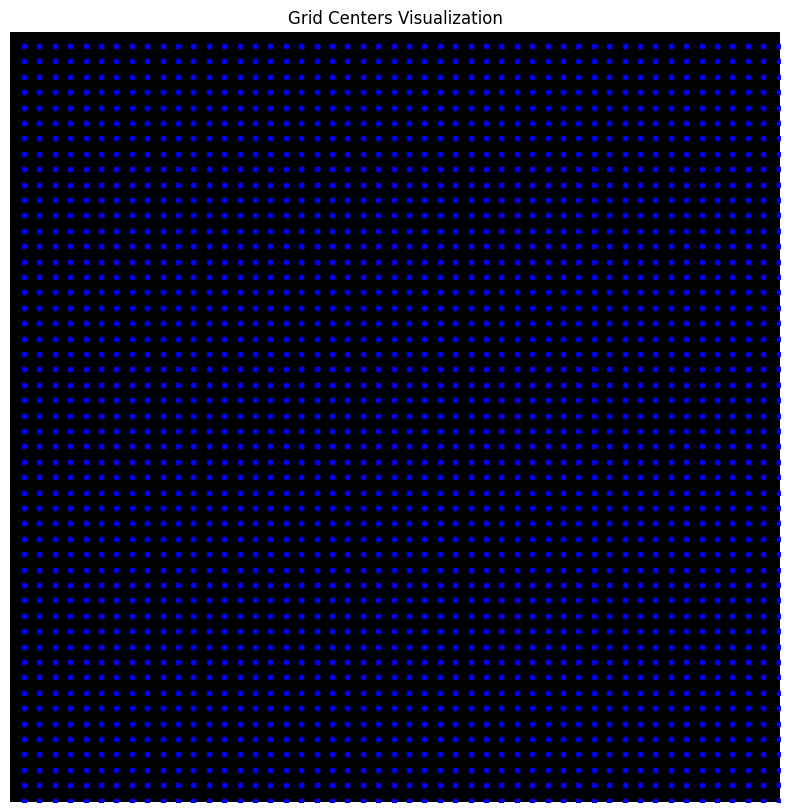

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
plt.imshow(np.zeros((800, 800)), cmap='gray')  # Create an empty image
plt.scatter(ctr[:, 1], ctr[:, 0], color='b', s=10)  # Plot grid centers
plt.title('Grid Centers Visualization')
plt.axis('off')
plt.show()

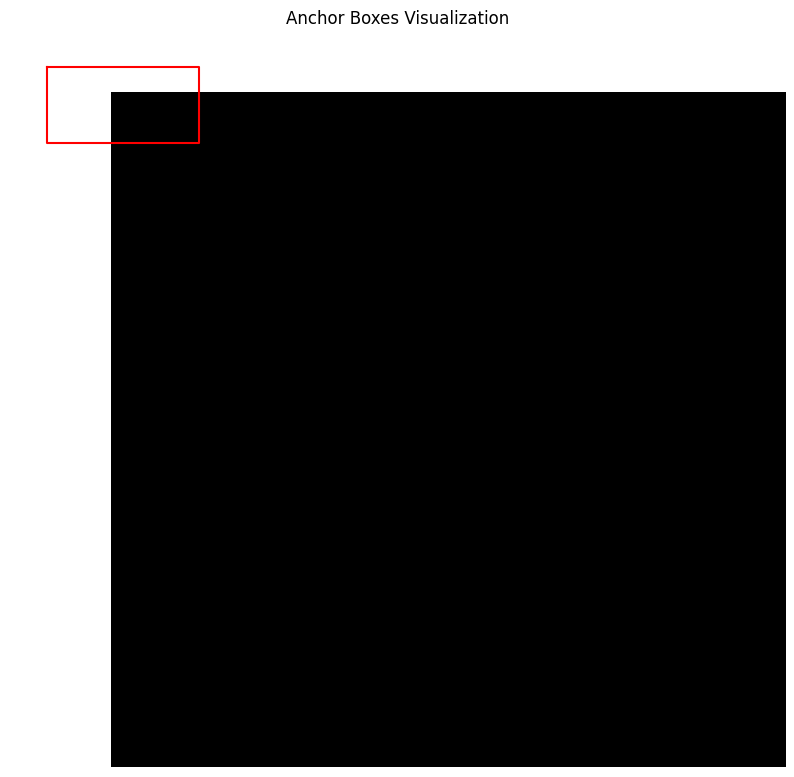

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(np.zeros((800,800)), cmap='gray')  # Create an empty image
for box in anchors:
    y1, x1, y2, x2 = box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
    break # delete the break and see all the anchors for all anchor locations
     # Plot anchor boxes
plt.title('Anchor Boxes Visualization')
plt.axis('off')
plt.show()

# We assign a positive label to two kind of anchors a) The anchor/anchors with the highest Intersection-over-Union(IoU) overlap with a ground-truth-box or b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box c) We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes. d) Anchors that are neither positive nor negitive do not contribute to the training objective.

In [ ]:
bbox = np.asarray([[20, 30, 400, 500], [300, 400, 500, 600]], dtype=np.float32) # [y1, x1, y2, x2] format
labels = np.asarray([6, 8], dtype=np.int8) # 0 represents background

# d) the anchors that are inside the image


In [ ]:
index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 800) &
        (anchors[:, 3] <= 800)
    )[0]
print(index_inside.shape)


(9130,)


In [ ]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)


(9130,)


In [ ]:
valid_anchor_boxes = anchors[index_inside]

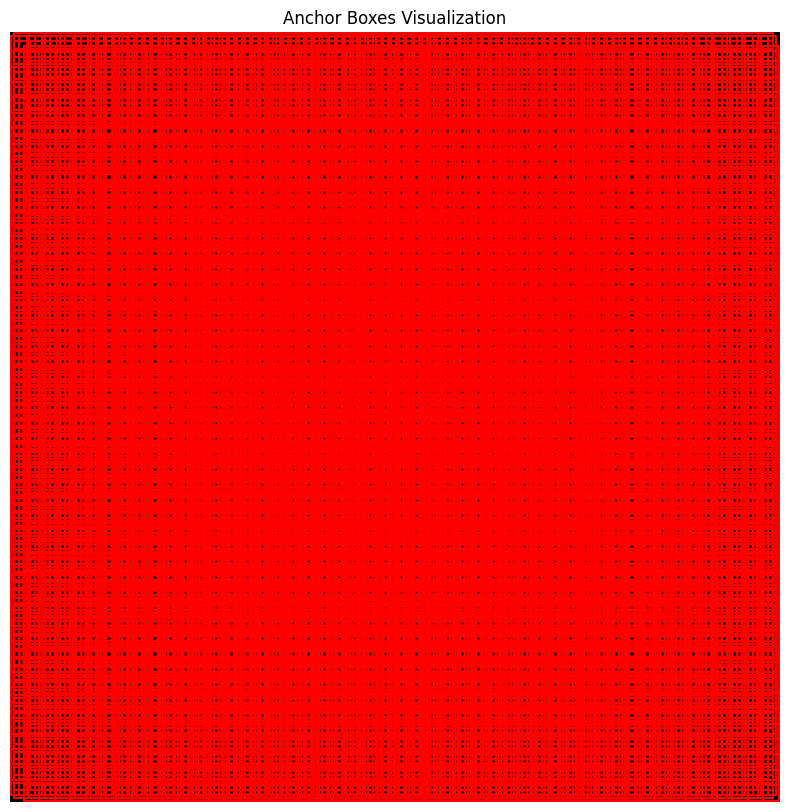

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(np.zeros((800,800)), cmap='gray')  # Create an empty image
for box in valid_anchor_boxes:
    y1, x1, y2, x2 = box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
     # delete the break and see all the anchors for all anchor locations
     # Plot anchor boxes
plt.title('Anchor Boxes Visualization')
plt.axis('off')
plt.show()

In [ ]:
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
print(bbox)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
    iter_area = (inter_y2 - inter_y1)*(inter_x2 - inter_x1)
    iou = iter_area /(anchor_area+ box_area - iter_area)
else:
    iou = 0.
ious[num1, num2] = iou
print(ious.shape)

[[ 20.  30. 400. 500.]
 [300. 400. 500. 600.]]
(9130, 2)
